# Best results in airbnb competition
### Random forest regressor 100 including zipcodes

In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('data/raw/train.csv')

In [3]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [9]:
df_feat = df.drop(['thumbnail_url', 'latitude', 'longitude', 'first_review',
                   'last_review', 'description', 'name', 'neighbourhood'], axis=1)
# neighbourhood

In [5]:
df_feat.isnull().sum()

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   133
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
host_has_profile_pic        127
host_identity_verified      127
host_response_rate        12551
host_since                  127
instant_bookable              0
number_of_reviews             0
review_scores_rating      11450
zipcode                     645
bedrooms                     63
beds                         85
dtype: int64

In [10]:
df_feat['zipcode'] = df_feat['zipcode'].astype(str)
df_feat['zipcode'] = df_feat['zipcode'].str[:5]
df_feat['zipcode'] = df_feat['zipcode'].apply(lambda x: x if len(x) >= 5 else '00000')

#host response rate
df_feat['host_response_rate'] = df_feat["host_response_rate"].str.strip("%")
df_feat['host_response_rate'] = pd.to_numeric(df_feat['host_response_rate'])
df_feat['host_response_rate'] = df_feat['host_response_rate'].fillna(round(df_feat['host_response_rate'].mean()))

#host_since
df_feat['host_since'] = pd.to_datetime(df_feat['host_since'])
df_feat['host_since'] = df_feat['host_since'].apply(lambda x : (pd.datetime.today() - x)/np.timedelta64(1,'D'))
df_feat['host_since'] = df_feat['host_since'].fillna(round(df_feat['host_since'].mean()))
df_feat['host_since'] = df_feat['host_since'].apply(np.floor)

#change cancelation policy to rating from 1 to 5
def cancelfee_rating(rating):
    if rating == 'flexible':
        return 1
    if rating == 'moderate':
        return 2
    if rating == 'strict':
        return 3
    if rating == 'super_strict_30':
        return 4
    if rating == 'super_strict_60':
        return 5
    return 0

df_feat['cancellation_policy']= df_feat['cancellation_policy'].apply(cancelfee_rating)

m_scores = df_feat['review_scores_rating'].mean()
m_bath = df_feat['bathrooms'].mean()
m_beds = df_feat['beds'].mean()
m_bedrooms = df_feat['bedrooms'].mean()
print(m_bath)
print(m_beds)
print(m_bedrooms)
print(m_scores)

# fill nulls with rounded means

print('before null', df_feat['review_scores_rating'].isnull().sum())
df_feat['review_scores_rating'] = df_feat['review_scores_rating'].fillna(round(m_scores))
print('after null', df_feat['review_scores_rating'].isnull().sum())

print('before null', df_feat['bathrooms'].isnull().sum())
df_feat['bathrooms'] = df_feat['bathrooms'].fillna(round(m_bath))
print('after null', df_feat['bathrooms'].isnull().sum())

print('before null', df_feat['beds'].isnull().sum() )
df_feat['beds'] = df_feat['beds'].fillna(round(m_beds))
print('after null', df_feat['beds'].isnull().sum())

print('before null', df_feat['bedrooms'].isnull().sum() )
df_feat['bedrooms'] = df_feat['bedrooms'].fillna(round(m_bedrooms))
print('after null', df_feat['bedrooms'].isnull().sum())

df_feat.dropna(inplace=True)
print('nulls left\n',df_feat.isnull().sum())

1.2324198399748363
1.7090837670627517
1.2656418713312523
94.0363590391909
before null 11450
after null 0
before null 133
after null 0
before null 85
after null 0
before null 63
after null 0
nulls left
 id                        0
log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_since                0
instant_bookable          0
number_of_reviews         0
review_scores_rating      0
zipcode                   0
bedrooms                  0
beds                      0
dtype: int64


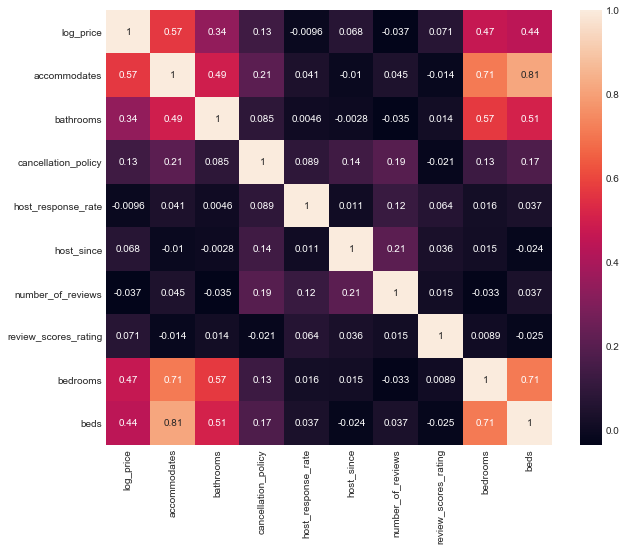

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(df_feat.select_dtypes(include=[np.number]).drop('id',axis=1).corr(),annot=True)

In [11]:
df_feat['amenities'] = df_feat['amenities'].str.replace("[{}]", "").str.replace('"', '').str.lower()
amenity_ohe = df_feat['amenities'].str.get_dummies(sep = ",")

# ['instant_bookable','cleaning_fee','bed_type','cancellation_policy','property_type','room_type','city']

df_instant_bookable = pd.get_dummies(df_feat['instant_bookable'], prefix='instant_bookable', drop_first=True)
df_cleaning_fee = pd.get_dummies(df_feat['cleaning_fee'], prefix='cleaning_fee', drop_first=True)
df_bed_type = pd.get_dummies(df_feat['bed_type'])
#df_cancellation_policy = pd.get_dummies(df_feat['cancellation_policy'])
df_property_type = pd.get_dummies(df_feat['property_type'])
df_room_type = pd.get_dummies(df_feat['room_type'])
df_city = pd.get_dummies(df_feat['city'])

df_host_has_profile_pic = pd.get_dummies(df_feat['host_has_profile_pic'], prefix='profile_pic', drop_first=True)
df_host_identity_verified = pd.get_dummies(df_feat['host_identity_verified'], prefix='verified', drop_first=True)

#df_neighbourhood = pd.get_dummies(df_feat['neighbourhood'])
df_zip = pd.get_dummies(df_feat['zipcode'])

df_feat = pd.concat([df_feat, df_instant_bookable, df_cleaning_fee, df_bed_type,
                     df_property_type, df_room_type, df_city, df_host_identity_verified,
                     df_host_has_profile_pic, 
                     #df_neighbourhood, 
                     df_zip,
                     amenity_ohe], axis=1)


new_cols = list(df_instant_bookable.columns) + list(df_cleaning_fee.columns) + list(df_bed_type.columns)\
+ list(df_room_type.columns) + list(df_city.columns) + list(df_property_type.columns)\
+ list(df_host_has_profile_pic.columns) + list(df_host_identity_verified.columns)\
+ list(df_zip.columns)\
+ list(amenity_ohe.columns)
#+ list(df_neighbourhood.columns)

In [12]:
# feature engineering
X_columns = ['accommodates','bathrooms','number_of_reviews','bedrooms','beds',
             'review_scores_rating', 'host_response_rate', 'host_since', 'cancellation_policy'] + new_cols
y_column = ['log_price']

In [13]:
# remove price outliers more than 3 sd
min_price = df_feat['log_price'].mean()-(3*df_feat['log_price'].std())
max_price = df_feat['log_price'].mean()+(3*df_feat['log_price'].std())
print('min',min_price)
print('max',max_price)


min 2.6335406189943456
max 6.9240507826295445


In [14]:
df_feat = df_feat.query('2.63 <= log_price <= 6.92')
print(df_feat.shape)

(50539, 827)


In [15]:
# split the data
X = df_feat[X_columns]
y = df_feat[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (35377, 815)
y_train (35377, 1)
X_test (15162, 815)
y_test (15162, 1)


In [11]:
#scale the data
#sc = StandardScaler()  
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [11]:
def model_training(model, X_train, y_train, X_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    return(y_pred)

def model_evaluation(title, model, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(title)
    print('MAE', round(mae, 2))
    print('RMSE', round(rmse, 2))
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head(50))
    return(mae, rmse)

def run_experiment(title, model, X_train, y_train, X_test, y_test):
    y_pred = model_training(model, X_train, y_train, X_test)
    mae, rmse = model_evaluation(title, model, y_test, y_pred)
    return(mae, rmse)

models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor150', RandomForestRegressor(n_estimators=150)),
    #('KNeighborsRegressor', KNeighborsRegressor()),
    #('DecisionTreeRegressor', DecisionTreeRegressor()),
]
results = []
for m in models:
    mae, rmse = run_experiment(m[0], m[1], X_train, y_train, X_test, y_test)
    results.append([m[0], mae, rmse])
    
# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'mae', 'rmse']
df_results = df_results.sort_values(by='mae')
df_results

LinearRegression
MAE 0.29
RMSE 0.39
RandomForestRegressor10
MAE 0.31
RMSE 0.42
Feature Importance
                                              0         1
16                              Entire home/apt  0.373130
1                                     bathrooms  0.099251
7                                    host_since  0.040079
2                             number_of_reviews  0.031230
3                                      bedrooms  0.027354
0                                  accommodates  0.026267
24                                           SF  0.017761
5                          review_scores_rating  0.015937
6                            host_response_rate  0.012612
22                                           LA  0.010903
18                                  Shared room  0.008612
724                                    elevator  0.008278
8                           cancellation_policy  0.007033
4                                          beds  0.006579
21                              

,model,mae,rmse
0,LinearRegression,0.291995,0.393503
2,RandomForestRegressor150,0.298284,0.399261
1,RandomForestRegressor10,0.313302,0.417958


RMSE 0.39


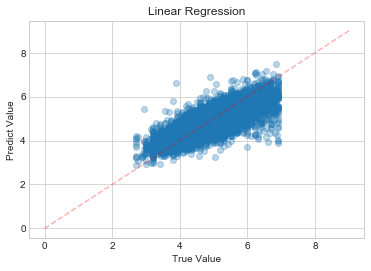

In [12]:
# train a linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE', round(rmse, 2))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

RMSE 0.4


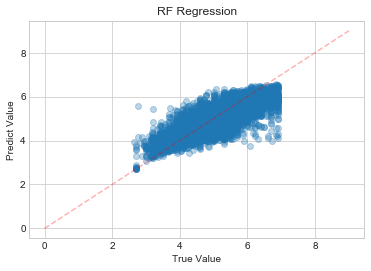

In [16]:
# train a random forest regression
rfr = RandomForestRegressor(n_estimators=150)
rfr.fit(X_train, y_train.values.ravel())
y_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE', round(rmse, 2))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('RF Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

## Duplicate transformations on the test set

In [17]:
df_test = pd.read_csv('data/raw/test.csv')

In [18]:
df_feat = df_test.drop(['thumbnail_url', 'latitude', 'longitude', 'first_review',
                   'last_review', 'description', 'name', 'neighbourhood'], axis=1)
# neighbourhood

In [19]:
#zipcode
df_feat['zipcode'] = df_feat['zipcode'].astype(str)
df_feat['zipcode'] = df_feat['zipcode'].str[:5]
df_feat['zipcode'] = df_feat['zipcode'].apply(lambda x: x if len(x) >= 5 else '00000')

#host response rate
df_feat['host_response_rate'] = df_feat["host_response_rate"].str.strip("%")
df_feat['host_response_rate'] = pd.to_numeric(df_feat['host_response_rate'])
df_feat['host_response_rate'] = df_feat['host_response_rate'].fillna(round(df_feat['host_response_rate'].mean()))

#host_since
df_feat['host_since'] = pd.to_datetime(df_feat['host_since'])
df_feat['host_since'] = df_feat['host_since'].apply(lambda x : (pd.datetime.today() - x)/np.timedelta64(1,'D'))
df_feat['host_since'] = df_feat['host_since'].fillna(round(df_feat['host_since'].mean()))
df_feat['host_since'] = df_feat['host_since'].apply(np.floor)

#change cancelation policy to rating from 1 to 5
def cancelfee_rating(rating):
    if rating == 'flexible':
        return 1
    if rating == 'moderate':
        return 2
    if rating == 'strict':
        return 3
    if rating == 'super_strict_30':
        return 4
    if rating == 'super_strict_60':
        return 5
    return 0

df_feat['cancellation_policy']= df_feat['cancellation_policy'].apply(cancelfee_rating)

m_scores = df_feat['review_scores_rating'].mean()
m_bath = df_feat['bathrooms'].mean()
m_beds = df_feat['beds'].mean()
m_bedrooms = df_feat['bedrooms'].mean()
print(m_bath)
print(m_beds)
print(m_bedrooms)
print(m_scores)

# fill nulls with rounded means

print('before null', df_feat['review_scores_rating'].isnull().sum())
df_feat['review_scores_rating'] = df_feat['review_scores_rating'].fillna(round(m_scores))
print('after null', df_feat['review_scores_rating'].isnull().sum())

print('before null', df_feat['bathrooms'].isnull().sum())
df_feat['bathrooms'] = df_feat['bathrooms'].fillna(round(m_bath))
print('after null', df_feat['bathrooms'].isnull().sum())

print('before null', df_feat['beds'].isnull().sum() )
df_feat['beds'] = df_feat['beds'].fillna(round(m_beds))
print('after null', df_feat['beds'].isnull().sum())

print('before null', df_feat['bedrooms'].isnull().sum() )
df_feat['bedrooms'] = df_feat['bedrooms'].fillna(round(m_bedrooms))
print('after null', df_feat['bedrooms'].isnull().sum())

df_feat['amenities'] = df_feat['amenities'].str.replace("[{}]", "").str.replace('"', '').str.lower()
amenity_ohe = df_feat['amenities'].str.get_dummies(sep = ",")

# ['instant_bookable','cleaning_fee','bed_type','cancellation_policy','property_type','room_type','city']

df_instant_bookable = pd.get_dummies(df_feat['instant_bookable'], prefix='instant_bookable', drop_first=True)
df_cleaning_fee = pd.get_dummies(df_feat['cleaning_fee'], prefix='cleaning_fee', drop_first=True)
df_bed_type = pd.get_dummies(df_feat['bed_type'])
#df_cancellation_policy = pd.get_dummies(df_feat['cancellation_policy'])
df_property_type = pd.get_dummies(df_feat['property_type'])
df_room_type = pd.get_dummies(df_feat['room_type'])
df_city = pd.get_dummies(df_feat['city'])

df_host_has_profile_pic = pd.get_dummies(df_feat['host_has_profile_pic'], prefix='profile_pic', drop_first=True)
df_host_identity_verified = pd.get_dummies(df_feat['host_identity_verified'], prefix='verified', drop_first=True)

#df_neighbourhood = pd.get_dummies(df_feat['neighbourhood'])
df_zip = pd.get_dummies(df_feat['zipcode'])

df_feat = pd.concat([df_feat, df_instant_bookable, df_cleaning_fee, df_bed_type,
                     df_property_type, df_room_type, df_city, df_host_identity_verified,
                     df_host_has_profile_pic,
                     df_zip,
                     amenity_ohe], axis=1)

#df_zip
#list(df_neighbourhood.columns)
#new_cols = list(df_instant_bookable.columns) + list(df_cleaning_fee.columns) + list(df_bed_type.columns)\
#+ list(df_room_type.columns) + list(df_city.columns) + list(df_property_type.columns)\
#+ list(df_host_has_profile_pic.columns) + list(df_host_identity_verified.columns)\
#+ list(df_neighbourhood.columns)\
#+ list(amenity_ohe.columns)

1.2415379274431522
1.7148059830912639
1.2661265866655114
94.13610628398453
before null 5272
after null 0
before null 67
after null 0
before null 46
after null 0
before null 28
after null 0


In [16]:
# run the linear prediction model on test
#X_columns = ['accommodates','bathrooms','number_of_reviews','bedrooms','beds','review_scores_rating'] + new_cols

df_prediction = df_feat.reindex(columns=X_columns, fill_value=0)
df_feat['log_price'] = lm.predict(df_prediction)
df_feat[['id', 'log_price']]

,id,log_price
0,986942,4.221358
1,16436737,4.501667
2,18209634,3.983811
3,15027024,4.152704
4,18074243,4.942254
5,8446914,5.208351
6,19362916,4.124715
7,16116059,5.817767
8,20912583,4.859584
9,13573101,4.979618


In [20]:
# run the random forest prediction model on test
#X_columns = ['accommodates','bathrooms','number_of_reviews','bedrooms','beds','review_scores_rating'] + new_cols

df_prediction = df_feat.reindex(columns=X_columns, fill_value=0)
df_feat['log_price'] = rfr.predict(df_prediction)
df_feat[['id', 'log_price']]

,id,log_price
0,986942,4.289441
1,16436737,4.361814
2,18209634,4.001196
3,15027024,4.312320
4,18074243,5.232439
5,8446914,5.103685
6,19362916,4.456792
7,16116059,6.062921
8,20912583,4.907686
9,13573101,4.923480


## Save the submission file

In [17]:
# linear model outliers removed. amenities, zipcode. no neighbourhoods. rmse .39
df_feat[['id', 'log_price']].to_csv('data/processed/linear_model_4.csv', index=False)

In [16]:
# random forest with 100 estimators, outliers removed. amenities, zipcode. no neighbourhoods
df_feat[['id', 'log_price']].to_csv('data/processed/random_forest_5_100.csv', index=False)

In [21]:
# random forest with 150 estimators, outliers removed. amenities, zipcode. no neighbourhoods. rmse .4
df_feat[['id', 'log_price']].to_csv('data/processed/random_forest_5_150.csv', index=False)